# 1st and Future - Player Contact Detection

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch

from sklearn.metrics import matthews_corrcoef

## Load data
> The description of the data can be found at the kaggle competition: https://www.kaggle.com/competitions/nfl-player-contact-detection/data

In [2]:
DATASET_DIR = "dataset"

# player tracking
train_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "train_player_tracking.csv"), 
                                       parse_dates=["datetime"])
test_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "test_player_tracking.csv"), 
                                      parse_dates=["datetime"])

# helmet detection
train_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "train_baseline_helmets.csv"))
test_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "test_baseline_helmets.csv"))

# video metadata
train_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "train_video_metadata.csv"), 
                                      parse_dates=["start_time", "end_time", "snap_time"])
test_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "test_video_metadata.csv"), 
                                      parse_dates=["start_time", "end_time", "snap_time"])

# train labels
train_labels_df =  pd.read_csv(os.path.join(DATASET_DIR, "train_labels.csv"), 
                               parse_dates=["datetime"])

### Check the player tracking dataframe

In [3]:
train_player_tracking_df.head()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58580_001136,58580,1136,44830,2021-10-10 21:08:20.900000+00:00,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64
1,58580_001136,58580,1136,47800,2021-10-10 21:08:20.900000+00:00,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90
2,58580_001136,58580,1136,52444,2021-10-10 21:08:20.900000+00:00,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33
3,58580_001136,58580,1136,46206,2021-10-10 21:08:20.900000+00:00,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62
4,58580_001136,58580,1136,52663,2021-10-10 21:08:20.900000+00:00,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31


In [4]:
train_player_tracking_df.describe()

,game_key,play_id,nfl_player_id,step,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
count,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06
mean,5.836580e+04,2.156408e+03,4.474702e+04,-1.190047e+01,5.128245e+01,6.030805e+01,2.675891e+01,1.259892e+00,1.287081e-01,1.796989e+02,1.802823e+02,7.931542e-01,-6.756010e-02
std,1.376961e+02,1.211457e+03,4.831883e+03,1.125495e+02,2.863610e+01,2.681538e+01,8.507395e+00,1.658213e+00,1.666470e-01,1.040005e+02,9.950983e+01,9.568293e-01,9.922022e-01
min,5.816800e+04,4.000000e+01,2.551100e+04,-3.390000e+02,1.000000e+00,-7.470000e+00,-1.287000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.310000e+01
25%,5.822500e+04,1.016000e+03,4.235200e+04,-8.600000e+01,2.500000e+01,3.848000e+01,2.249000e+01,1.200000e-01,2.000000e-02,9.003000e+01,8.994000e+01,1.500000e-01,-3.800000e-01
50%,5.833000e+04,2.369000e+03,4.489300e+04,-1.500000e+01,5.200000e+01,5.969000e+01,2.674000e+01,6.500000e-01,7.000000e-02,1.792400e+02,1.802300e+02,4.700000e-01,-3.000000e-02
75%,5.851600e+04,3.139000e+03,4.781400e+04,4.900000e+01,7.600000e+01,8.171000e+01,3.104000e+01,1.620000e+00,1.600000e-01,2.693300e+02,2.701700e+02,1.040000e+00,1.600000e-01
max,5.858200e+04,4.644000e+03,5.398500e+04,6.920000e+02,9.900000e+01,1.256500e+02,6.372000e+01,1.489000e+01,2.220000e+00,3.600000e+02,3.600000e+02,3.355000e+01,3.355000e+01


In [5]:
train_player_tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353053 entries, 0 to 1353052
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   game_play      1353053 non-null  object             
 1   game_key       1353053 non-null  int64              
 2   play_id        1353053 non-null  int64              
 3   nfl_player_id  1353053 non-null  int64              
 4   datetime       1353053 non-null  datetime64[ns, UTC]
 5   step           1353053 non-null  int64              
 6   team           1353053 non-null  object             
 7   position       1353053 non-null  object             
 8   jersey_number  1353053 non-null  int64              
 9   x_position     1353053 non-null  float64            
 10  y_position     1353053 non-null  float64            
 11  speed          1353053 non-null  float64            
 12  distance       1353053 non-null  float64            
 13  direction   

### Check the helmet detection dataframe

In [6]:
train_helmet_detection_df.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


In [7]:
train_helmet_detection_df.describe()

,game_key,play_id,frame,nfl_player_id,left,width,top,height
count,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06
mean,5.837021e+04,2.186813e+03,5.176293e+02,4.492682e+04,6.295490e+02,1.794553e+01,3.050392e+02,1.902664e+01
std,1.396644e+02,1.195722e+03,1.569070e+02,4.762725e+03,2.665431e+02,8.656632e+00,1.192583e+02,9.384617e+00
min,5.816800e+04,4.000000e+01,2.890000e+02,2.551100e+04,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00
25%,5.822700e+04,1.076000e+03,3.920000e+02,4.237200e+04,4.440000e+02,1.100000e+01,2.350000e+02,1.200000e+01
50%,5.833200e+04,2.375000e+03,4.970000e+02,4.492600e+04,6.320000e+02,1.600000e+01,3.010000e+02,1.700000e+01
75%,5.852400e+04,3.151000e+03,6.170000e+02,4.782500e+04,8.150000e+02,2.400000e+01,3.720000e+02,2.500000e+01
max,5.858200e+04,4.644000e+03,1.326000e+03,5.398500e+04,1.278000e+03,8.200000e+01,7.180000e+02,8.900000e+01


In [8]:
train_helmet_detection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3783616 entries, 0 to 3783615
Data columns (total 12 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   game_play      object
 1   game_key       int64 
 2   play_id        int64 
 3   view           object
 4   video          object
 5   frame          int64 
 6   nfl_player_id  int64 
 7   player_label   object
 8   left           int64 
 9   width          int64 
 10  top            int64 
 11  height         int64 
dtypes: int64(8), object(4)
memory usage: 346.4+ MB


### Check the video metadata dataframe

In [9]:
train_video_metadata_df.head()

,game_play,game_key,play_id,view,start_time,end_time,snap_time
0,58168_003392,58168,3392,Endzone,2020-09-11 03:01:43.134000+00:00,2020-09-11 03:01:54.971000+00:00,2020-09-11 03:01:48.134000+00:00
1,58168_003392,58168,3392,Sideline,2020-09-11 03:01:43.134000+00:00,2020-09-11 03:01:54.971000+00:00,2020-09-11 03:01:48.134000+00:00
2,58172_003247,58172,3247,Endzone,2020-09-13 19:30:42.414000+00:00,2020-09-13 19:31:00.524000+00:00,2020-09-13 19:30:47.414000+00:00
3,58172_003247,58172,3247,Sideline,2020-09-13 19:30:42.414000+00:00,2020-09-13 19:31:00.524000+00:00,2020-09-13 19:30:47.414000+00:00
4,58173_003606,58173,3606,Endzone,2020-09-13 19:45:07.527000+00:00,2020-09-13 19:45:26.438000+00:00,2020-09-13 19:45:12.527000+00:00


In [10]:
train_video_metadata_df.describe(include="all", datetime_is_numeric=True)

,game_play,game_key,play_id,view,start_time,end_time,snap_time
count,480,480.000000,480.000000,480,480,480,480
unique,240,NaN,NaN,2,NaN,NaN,NaN
top,58168_003392,NaN,NaN,Endzone,NaN,NaN,NaN
freq,2,NaN,NaN,240,NaN,NaN,NaN
mean,NaN,58370.787500,2177.420833,NaN,2021-02-24 22:10:23.570112512+00:00,2021-02-24 22:10:36.502428928+00:00,2021-02-24 22:10:28.570099968+00:00
min,NaN,58168.000000,40.000000,NaN,2020-09-11 03:01:43.134000+00:00,2020-09-11 03:01:54.971000+00:00,2020-09-11 03:01:48.134000+00:00
25%,NaN,58231.500000,1077.500000,NaN,2020-10-11 18:04:45.717750016+00:00,2020-10-11 18:04:59.388000+00:00,2020-10-11 18:04:50.717750016+00:00
50%,NaN,58331.500000,2348.500000,NaN,2020-11-29 19:27:53.588499968+00:00,2020-11-29 19:28:07.249999872+00:00,2020-11-29 19:27:58.588499968+00:00
75%,NaN,58521.000000,3125.500000,NaN,2021-09-19 17:09:15.293000192+00:00,2021-09-19 17:09:27.694999808+00:00,2021-09-19 17:09:20.293000192+00:00
max,NaN,58582.000000,4644.000000,NaN,2021-10-12 02:42:15.078000+00:00,2021-10-12 02:42:29.118000+00:00,2021-10-12 02:42:20.078000+00:00


In [11]:
train_video_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   game_play   480 non-null    object             
 1   game_key    480 non-null    int64              
 2   play_id     480 non-null    int64              
 3   view        480 non-null    object             
 4   start_time  480 non-null    datetime64[ns, UTC]
 5   end_time    480 non-null    datetime64[ns, UTC]
 6   snap_time   480 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), int64(2), object(2)
memory usage: 26.4+ KB


### Check the train labels dataframe

In [12]:
train_labels_df.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,43854,0
1,58168_003392_0_38590_41257,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41257,0
2,58168_003392_0_38590_41944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41944,0
3,58168_003392_0_38590_42386,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,42386,0
4,58168_003392_0_38590_47944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,47944,0


In [13]:
train_labels_df.describe(include="all", datetime_is_numeric=True)

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
count,4721618,4721618,4721618,4.721618e+06,4.721618e+06,4721618,4.721618e+06
unique,4721618,240,NaN,NaN,NaN,1646,NaN
top,58168_003392_0_38590_43854,58537_000757,NaN,NaN,NaN,G,NaN
freq,1,43769,NaN,NaN,NaN,410633,NaN
mean,NaN,NaN,2021-02-23 13:03:45.332655104+00:00,4.074472e+01,4.249579e+04,NaN,1.366523e-02
min,NaN,NaN,2020-09-11 03:01:48.100000+00:00,0.000000e+00,2.551100e+04,NaN,0.000000e+00
25%,NaN,NaN,2020-10-04 21:24:56.600000+00:00,1.900000e+01,4.007000e+04,NaN,0.000000e+00
50%,NaN,NaN,2020-11-29 18:08:21.100000+00:00,3.800000e+01,4.266700e+04,NaN,0.000000e+00
75%,NaN,NaN,2021-09-17 03:13:29.400000+00:00,5.900000e+01,4.500500e+04,NaN,0.000000e+00
max,NaN,NaN,2021-10-12 02:42:29.100000+00:00,1.720000e+02,5.398500e+04,NaN,1.000000e+00


In [14]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721618 entries, 0 to 4721617
Data columns (total 7 columns):
 #   Column           Dtype              
---  ------           -----              
 0   contact_id       object             
 1   game_play        object             
 2   datetime         datetime64[ns, UTC]
 3   step             int64              
 4   nfl_player_id_1  int64              
 5   nfl_player_id_2  object             
 6   contact          int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 252.2+ MB


* We can see that nfl_player_id_2	is an object and not an integer, as it can have the value 'G' to indicate a contact with the ground

## Utils

In [15]:
def array_to_image(image_array):
    """returns a PIL image converted from the given image array"""
    return Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))

In [16]:
def get_video_frame(game_play, frame_number, view='All29', split="train"):
    """
    Returns the given frame from the video given by the game_play value and the indicated view.
    Videos have the name in the following format: "game_play_view"
    
    Parameters:
    game_play (string): game_play id.
    frame (int): the frame we want to extract.
    view (string): the view option we want to extract the frame from. The possible values are:
    ['All29', 'Endzone', 'Sideline'].
    split (string): the dataset split we want to extract the video from. It can be "train" or "test"
    
    Returns:
    PIL Image
    """
    video_name = f"{game_play}_{view}.mp4"
    videopath = os.path.join(DATASET_DIR, split, video_name)
    cap = cv2.VideoCapture(videopath)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    res, frame = cap.read()
    
    return frame

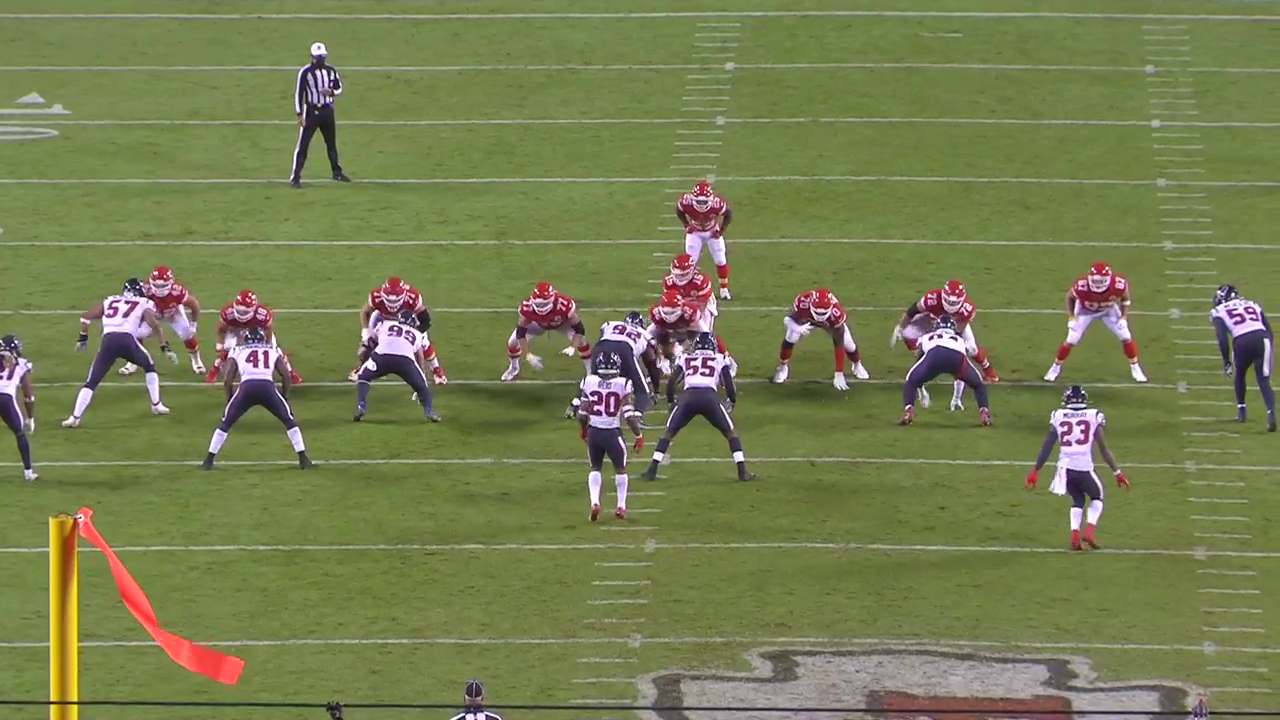

In [17]:
array_to_image(get_video_frame("58168_003392", 300, 'Endzone', "train"))

In [18]:
def draw_boxes(boxes, labels, image, color=(0, 0, 0)):
    """
    Returns an image array that contains the predicted bounding boxes, labels and scores
    """
    # read the image with OpenCV
    image = np.asarray(image)
    for i, box in enumerate(boxes):
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), # top-left corner
                     (int(box[2]), int(box[3])), # bottom-right corner
                     color, 2)
        # showing probability scores
        bbox_text = f"{labels[i]}" 
        cv2.putText(image, bbox_text, (int(box[0]), int(box[1]) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, thickness=1,
                   lineType=cv2.LINE_AA)
    
    return image

In [19]:
def draw_helmet_detection(helmet_detection_df, game_play, frame_number, view='Endzone', split="train"):
    """
    Returns the given frame from the video given by the game_play value and the indicated view
    with the drawn detection boxes and labels.
    Videos have the name in the following format: "game_play_view"
    
    Parameters:
    helmet_detection_df: the helmet detection dataframe
    game_play (string): game_play id.
    frame (int): the frame we want to extract.
    view (string): the view option we want to extract the frame from. The possible values are:
    ['All29', 'Endzone', 'Sideline'].
    split (string): the dataset split we want to extract the video from. It can be "train" or "test"
    
    Returns:
    PIL Image
    """
    frame = get_video_frame(game_play, frame_number, view, split)
    detections = helmet_detection_df[(helmet_detection_df['frame'] == frame_number) & 
                            (helmet_detection_df['view'] == view) &
                            (helmet_detection_df['game_play'] == game_play)
                            ][['left', 'width', 'top', 'height', 'player_label']].values

    boxes, labels = detections[:, :-1], detections[:, -1]
    # convert boxes to standard format of:
    # [xmin, ymin, xmax, xmax]
    boxes_st = boxes.copy()
    boxes_st[:, 1] = boxes[:, 2] # ymin
    boxes_st[:, 2] = boxes[:, 0] + boxes[:, 1] # xmax
    boxes_st[:, 3] = boxes[:, 2] + boxes[:, 3] # ymax
    
    # draw the detection boxes
    frame = draw_boxes(boxes_st, labels, frame, color=(0,0,0))
    
    return frame

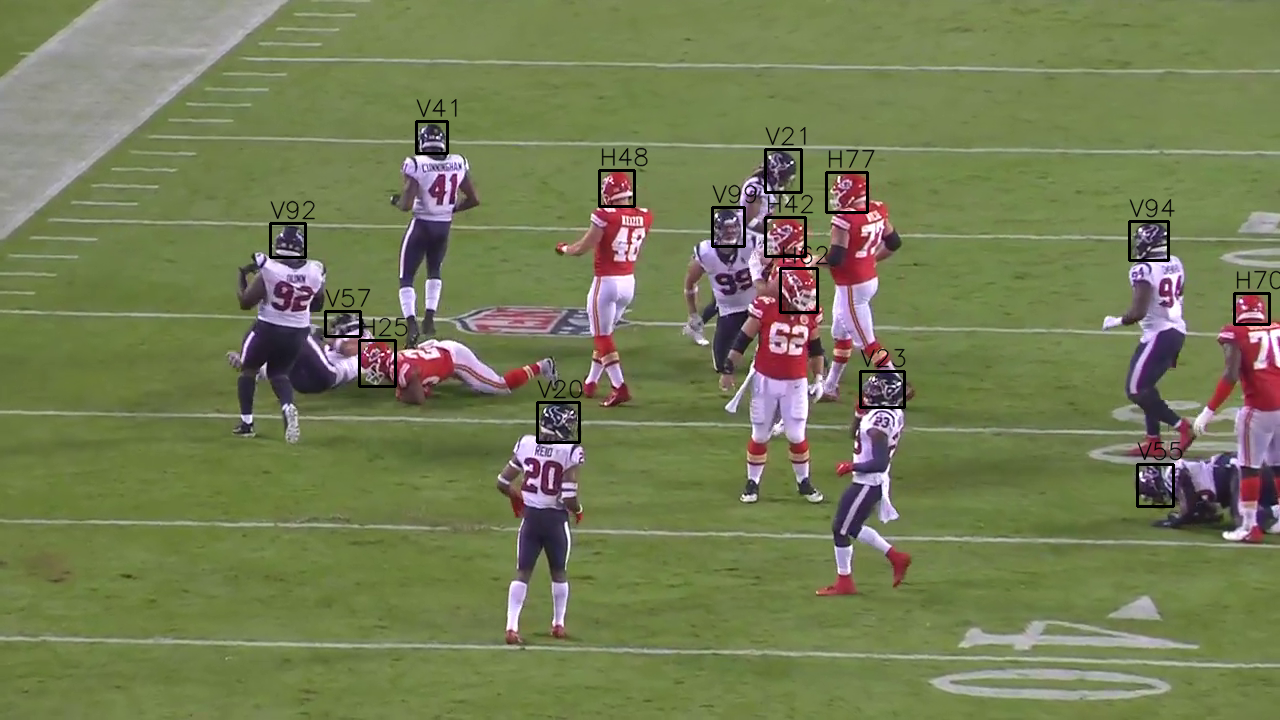

In [22]:
array_to_image(draw_helmet_detection(train_helmet_detection_df, 
                                     "58168_003392", 
                                     600, 
                                     'Endzone', 
                                     "train"))

## YOLO person detection

In [24]:
def get_yolo_detections(yolo_model, image, confidence=0.5):
    """
    Carries out object detection on the given image using the given yolo model.
    Only the detections with a higher confidence interval than the given value are returned.
    Returns a list of bounding box coordinates in the format: ['xmin', 'ymin', 'xmax', 'ymax']
    And a list of the class names of each bounding box.
    """
    results = yolo_model(image)
    results_df = results.pandas().xyxy[0]
    results_df = results_df[results_df['confidence'] > confidence]
    detections = results_df[['xmin', 'ymin', 'xmax', 'ymax', 'name']].values
    boxes, labels = detections[:, :-1], detections[:, -1]
    
    return boxes, labels

In [25]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\AT016638/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-12-15 Python-3.9.7 torch-1.10.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


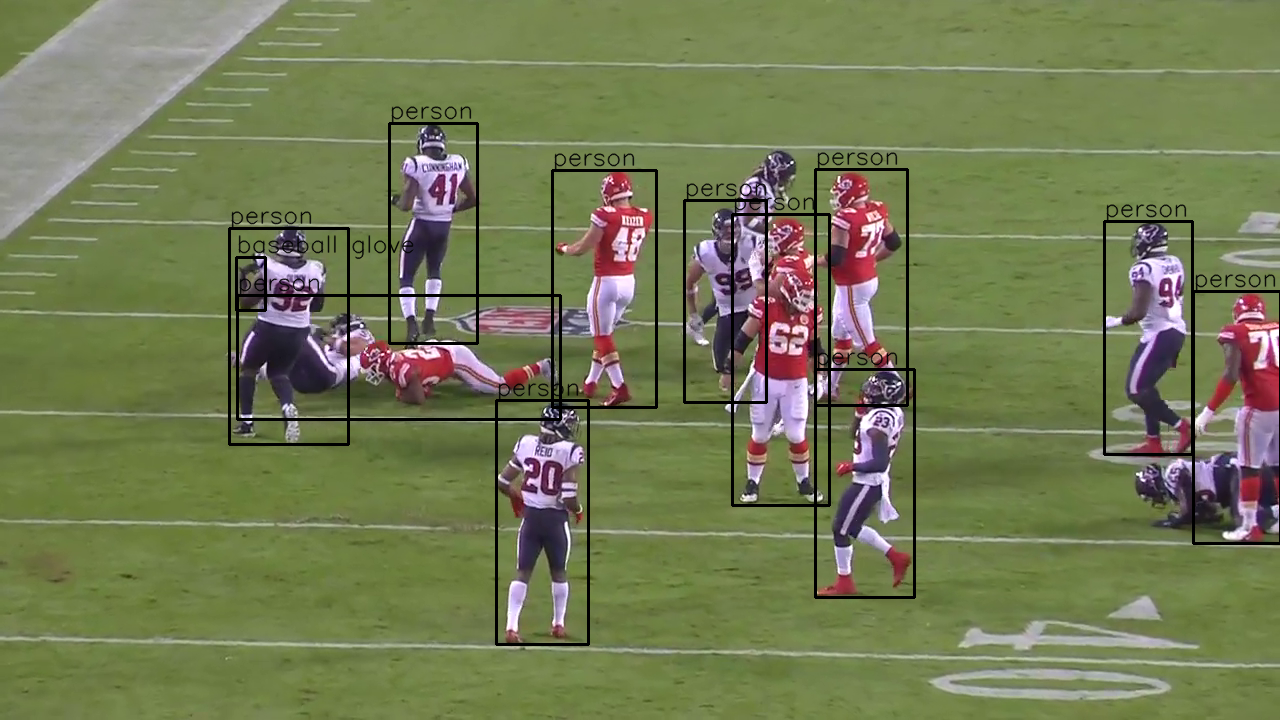

In [29]:
image_array = get_video_frame("58168_003392", 600, 'Endzone', "train")
image = array_to_image(image_array)
boxes, labels = get_yolo_detections(yolo_model, image, 0.3)
array_to_image(draw_boxes(boxes, labels, image_array))

## Data Preprocessing

### Extract the contact info

In [24]:
def extract_contact_id_info(input_df):
    # game_key, play_id, player_1_id, player_2_id, step
    contact_df = pd.DataFrame()
    split = input_df['contact_id'].str.split("_")
    contact_df['contact_id'] = input_df['contact_id']
    contact_df['game_play'] = split.str[0]+'_'+split.str[1]
    contact_df['step'] = split.str[2].astype("int")
    contact_df['nfl_player_id_1'] = split.str[3]
    contact_df['nfl_player_id_2'] = split.str[4]
    # replace ground 'G' players id with '-1'
    contact_df.loc[contact_df["nfl_player_id_2"] == 'G', 'nfl_player_id_2'] = '-1'
    contact_df['nfl_player_id_1'] = contact_df['nfl_player_id_1'].astype('int')
    contact_df['nfl_player_id_2'] = contact_df['nfl_player_id_2'].astype('int')
    
    return contact_df

In [25]:
def add_contact_tracking_info(contact_df, tracking_df):
    """
    Joins a contact dataframe with player tracking dataframe on both players
    """
    player_specific_columns=["team", "position", "jersey_number",
                              "x_position", "y_position", "speed", 
                              "distance", "direction", "orientation",
                              "acceleration", "sa"]
    # join on player 1
    contact_df = contact_df.merge(tracking_df, 
                                 left_on=['game_play', 'nfl_player_id_1', 'step'], 
                                 right_on=['game_play', 'nfl_player_id', 'step'], 
                                 how='left').drop_duplicates()
    # remove the repeated column
    contact_df.drop(["nfl_player_id"], axis=1, inplace=True)
    # rename player 1 specific tracking data
    contact_df.rename(columns=lambda x: x+'_1' if x in player_specific_columns else x, inplace=True)

    # join on player 2
    # avoid repeating the "game_key", "play_id", 'datetime' columns
    contact_df = contact_df.merge(tracking_df.drop(['game_key', 'play_id', 'datetime'], axis=1), 
                                 left_on=['game_play', 'nfl_player_id_2', 'step'], 
                                 right_on=['game_play', 'nfl_player_id', 'step'], 
                                 how='left').drop_duplicates()
    # remove the repeated column
    contact_df.drop("nfl_player_id", axis=1, inplace=True)
    # rename player 2 specific tracking data
    contact_df.rename(columns=lambda x: x+'_2' if x in player_specific_columns else x, inplace=True)
    contact_df.replace(np.nan, 0, inplace=True)
    
    return contact_df

In [26]:
def add_ground_truth_data(contact_df, train_labels_df):
    # get ground truth contact data
    contact_df['contact_truth'] =  contact_df.merge(train_labels_df, 
                                         left_on='contact_id', 
                                         right_on='contact_id', 
                                         how='left').drop_duplicates()['contact']
    return contact_df
    

### Computing the distance between players

In [33]:
def compute_distance(contact_df):
    # compute the distance between 2 players
    contact_df["p2p_distance"] = np.sqrt(
        np.square(contact_df["x_position_1"] - contact_df["x_position_2"])
        + np.square(contact_df["y_position_1"] - contact_df["y_position_2"])
    )
    # set the distance between a player and the ground to 999
    contact_df.loc[contact_df["nfl_player_id_2"]==-1, 'p2p_distance'] = 999
    contact_df['p2p_distance'] = contact_df['p2p_distance'].fillna(999)
    return contact_df

### Final preprocessing function

In [28]:
def preprocess_input(input_df):
    """Returns the preprocessed dataframe with all the expanded contact_id info, tracking data, distance
    and ground truth"""
    # train tracking df contains all data from the test tracking df
    contact_df = extract_contact_id_info(input_df)
    # add tracking info to the contact df
    contact_df = add_contact_tracking_info(contact_df, train_player_tracking_df)
    contact_df = contact_df.fillna(0)
    # compute player distance
    contact_df = compute_distance(contact_df)

    return contact_df

In [29]:
contact_df = preprocess_input(train_labels_df)
# add ground truth data
contact_df = add_ground_truth_data(contact_df, train_labels_df)

print(contact_df.columns)
contact_df

Index(['contact_id', 'game_play', 'step', 'nfl_player_id_1', 'nfl_player_id_2',
       'game_key', 'play_id', 'datetime', 'team_1', 'position_1',
       'jersey_number_1', 'x_position_1', 'y_position_1', 'speed_1',
       'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1',
       'team_2', 'position_2', 'jersey_number_2', 'x_position_2',
       'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2',
       'acceleration_2', 'sa_2', 'p2p_distance', 'contact_truth'],
      dtype='object')


,contact_id,game_play,step,nfl_player_id_1,nfl_player_id_2,...,orientation_2,acceleration_2,sa_2,p2p_distance,contact_truth
0,58168_003392_0_38590_43854,58168_003392,0,38590,43854,...,294.74,1.74,1.74,8.650763,0
1,58168_003392_0_38590_41257,58168_003392,0,38590,41257,...,270.88,0.34,0.08,11.112592,0
2,58168_003392_0_38590_41944,58168_003392,0,38590,41944,...,282.07,0.81,0.81,2.948525,0
3,58168_003392_0_38590_42386,58168_003392,0,38590,42386,...,269.45,1.11,1.10,5.711716,0
4,58168_003392_0_38590_47944,58168_003392,0,38590,47944,...,266.04,1.63,1.23,2.196110,0
...,...,...,...,...,...,...,...,...,...,...,...
4721613,58582_003121_91_48220_G,58582_003121,91,48220,-1,...,0.00,0.00,0.00,999.000000,0
4721614,58582_003121_91_47906_G,58582_003121,91,47906,-1,...,0.00,0.00,0.00,999.000000,0
4721615,58582_003121_91_38557_G,58582_003121,91,38557,-1,...,0.00,0.00,0.00,999.000000,0
4721616,58582_003121_91_47872_G,58582_003121,91,47872,-1,...,0.00,0.00,0.00,999.000000,0


In [30]:
contacts = contact_df['contact_truth'].values.sum()
print(f"There are {contacts} positive contacts out of {len(contact_df)} input contact_ids")

There are 64522 positive contacts out of 4721618 input contact_ids


## Naive Prediction

In [31]:
# best_score = 0
# best_thrs = 0
# # find the best distance threshold with steps of 0.1
# for thrs in np.arange(0.0, 5.0, 0.1):
#     predictions = (contact_df['p2p_distance'] < thrs).astype(int)
#     score = matthews_corrcoef(contact_df['contact_truth'], predictions)
#     if score > best_score:
#         best_score = score
#         best_thrs = thrs
        
# contact_df['contact'] = (contact_df['p2p_distance'] < best_thrs).astype(int)
# print(f'Matthew’s correlation coefficient = {best_score} for distance threshold: {best_thrs:.2f}')

Matthew’s correlation coefficient = 0.5250721214484124 for distance threshold: 1.10

## Create submission

In [32]:
# load the submission dataframe
input_df = pd.read_csv(os.path.join(DATASET_DIR, "sample_submission.csv"))

THRS = 1.1

contact_df = preprocess_input(input_df)
contact_df['contact'] = (contact_df['p2p_distance'] < THRS).astype(int)


submission = contact_df[["contact_id", "contact"]].copy()
submission['contact'] = submission['contact'].fillna(0).astype('int')
submission[["contact_id", "contact"]].to_csv("submission.csv", index=False)

submission

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0
...,...,...
49583,58172_003247_125_40656_G,0
49584,58172_003247_125_52521_G,0
49585,58172_003247_125_52939_G,0
49586,58172_003247_125_39008_G,0
